In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
plt.rcParams['font.family'] = ['sans-serif'] #显示中文标签
plt.rcParams['font.sans-serif']=['SimHei'] 
plt.rcParams['axes.unicode_minus']=False

In [3]:
x0 = np.array([174,179,183,189,207,234,220.5,256,270,285])
year = np.array(np.arange(1995,2005))

In [111]:
class GrayPre:
    def __init__(self,xdata,ydata):
        self.xdata = xdata
        self.ydata = ydata
        self.n = len(ydata)
        if self.xdata.shape[0] > 1:
            self.xdata = self.xdata.reshape(-1,1)
        if self.ydata.shape[0] > 1:
            self.ydata = self.ydata.reshape(-1,1)

        if True in self.ydata < 0:
            print('不能有负数')
        print('原始数据长度：%s' % self.n)
        if self.n <= 3:
            print('数据量太小')
        elif self.n > 10:
            print('可以考虑使用其他方法进行预测')
    
    def gplot(self,gxlabel,gylabel):
        plt.plot(self.xdata,self.ydata, marker='o', markerfacecolor='none')
        plt.grid()
        plt.xlabel(gxlabel)
        plt.ylabel(gylabel)
        plt.show()
        
    def expon_test(self):
        print('准指数规律检验')
        year = self.xdata
        x0 = self.ydata
        # 累加x0
        x1 = np.cumsum(x0).reshape(-1,1)
        # 计算光滑度 rho(k)=x0(k)/x1(k-1)
        rho = x0[1:] / x1[:-1]
        # 统计小于0.5的个数
        print(sum((rho<0.5).astype(int))[0])
        plt.plot(year[1:], rho, marker='o', markerfacecolor='none')
        plt.grid()
        plt.axhline(y=0.5, color='r', linestyle='--', label='平均违约率')
        plt.text(year[-3]-1,0.55,'临界线：y=0.5',fontsize=15)
        
    train_x0 = x0[:-3]  
    test_x0 = x0[-3:]
    
    def gm11(self,test_num=3,pre_num=3):
        x0 = self.ydata
        # 训练数据
        
        n = len(x0)
        x1 = np.cumsum(x0).reshape(-1,1)
        z1 = (x1[:-1]+x1[1:]) / 2
        y = x0[1:]
        x = z1
        reg = LinearRegression()
        reg.fit(x,y)
        a = -np.unique(reg.coef_)[0]
        b = np.unique(reg.intercept_)[0]
        x0_hat = np.zeros((n,1))
        x0_hat[0] = x0[0]
        for i in range(n-1):
            x0_hat[i+1] = (1-np.exp(a)) * (x0[0]-b/a) * np.exp(-a*(i+1))
        self.x0_hat = x0_hat
        result = np.zeros((pre_num,1))
        
        for i in range(pre_num):
            result[i] = (1-np.exp(a)) * (x0[0]-b/a) * np.exp(-a*(n+i))

        self.result = result
        
        # 绝对残差与相对残差
        absolute_residuals = x0[1:] - x0_hat[1:]
        relative_residuals = abs(absolute_residuals) / x0[1:]
        # 级比与级比偏差
        class_ratio = x0[1:] / x0[:-1]
        eta = abs(1-(1-0.5*a) / (1+0.5*a) * (1/class_ratio))
        self.eta = eta
        plt.plot(year[1:],relative_residuals)
        return result
        
    def new_gm11(self,x0,pre_num1=3):
        result1 = np.zeros((pre_num1,1))
        x0_ = x0
        for i in range(pre_num1):
            result1[i] = self.sigle_compute_result(x0=x0_,pred_num=1)
            x0_ = np.append(x0_,result1[i])
        return result1
    
    def sigle_compute_result(self,x0,pred_num=3):
        n = len(x0)
        x1 = np.cumsum(x0).reshape(-1,1)
        z1 = (x1[:-1]+x1[1:]) / 2
        y = x0[1:]
        x = z1
        reg = LinearRegression()
        reg.fit(x,y)
        a = -np.unique(reg.coef_)[0]
        b = np.unique(reg.intercept_)[0]
        sigle_result = np.zeros((pred_num,1))
        for i in range(pred_num):
            sigle_result[i] = (1-np.exp(a)) * (x0[0]-b/a) * np.exp(-a*(n+i))
        
        return sigle_result
        
    def metab_gm11(self,x0,pre_num2=3):
        result2 = np.zeros((pre_num2,1))
        x0__ = x0
        for i in range(pre_num2):
            result2[i] = self.sigle_compute_result(x0=x0__,pred_num=1)
            x0__ = np.append(x0__[1:], result2[i])
        return result2
    
    def draw_result(self):
        x0 = self.ydata[-3:]
        gm11_result = self.sigle_compute_result(x0=self.train_x0)
        new_gm11_result = self.new_gm11(x0=self.train_x0)
        metab_gm11_result = self.metab_gm11(x0=self.train_x0)
        pred_year = self.xdata[-3:]
        plt.plot(pred_year,x0,label='原始数据')
        plt.plot(pred_year,gm11_result,label='gm11预测结果')
        plt.plot(pred_year,new_gm11_result,label='新gm11预测结果')
        plt.plot(pred_year,metab_gm11_result,label='新陈代谢gm11预测结果')
        plt.MultipleLocator(1)
        plt.xticks(np.arange(pred_year[0],pred_year[-1]+1,1))
        plt.legend()
        
    def compute_sse(self):
        gm11_result = self.sigle_compute_result(x0=self.train_x0)
        new_gm11_result = self.new_gm11(x0=self.train_x0)
        metab_gm11_result = self.metab_gm11(x0=self.train_x0)

        sse1 = sum((self.test_x0.reshape(-1,1)-gm11_result) **2)
        sse2 = sum((self.test_x0.reshape(-1,1)-new_gm11_result) **2)
        sse3 = sum((self.test_x0.reshape(-1,1)-metab_gm11_result) **2)
        print('传统GM(1,1)预测误差平方和：',sse1[0])
        print('新GM(1,1)预测误差平方和：',sse2[0])
        print('新陈代谢GM(1,1)预测误差平方和：',sse3[0])

原始数据长度：10


array([[303.01223193],
       [322.52210378],
       [343.28814636]])

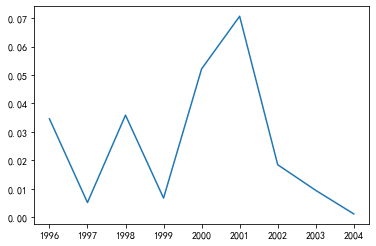

In [112]:
a = GrayPre(xdata=year,ydata=x0)

a.gm11()

In [6]:
np.append(x0,[1,3,4])

array([174. , 179. , 183. , 189. , 207. , 234. , 220.5, 256. , 270. ,
       285. ,   1. ,   3. ,   4. ])

In [7]:
a.eta

array([0.03270106, 0.02618425, 0.05650452, 0.13185971, 0.08134178,
       0.01125699, 0.01042536, 0.0031596 , 0.00352941])

In [31]:
np.exp(2)

7.38905609893065

原始数据长度：10
准指数规律检验
7


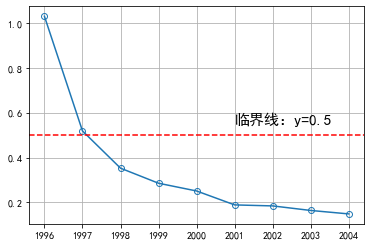

In [5]:
a.expon_test()

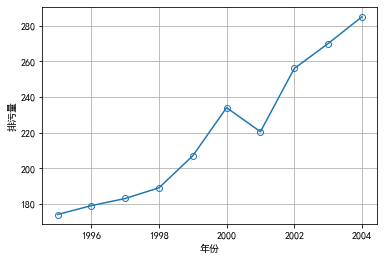

In [186]:
a.gplot('年份','排污量')

In [46]:
True in x0 < 0

False

In [85]:
year = np.array(np.arange(1995,2005)).reshape(-1,1)
x0 = np.array([174,179,183,189,207,234,220.5,256,270,285]).reshape(-1,1)

In [86]:
np.cumsum(x0)

array([ 174. ,  353. ,  536. ,  725. ,  932. , 1166. , 1386.5, 1642.5,
       1912.5, 2197.5])

In [107]:
LinearRegression??

Init signature:
LinearRegression(
    *,
    fit_intercept=True,
    normalize=False,
    copy_X=True,
    n_jobs=None,
)
Source:        
class LinearRegression(MultiOutputMixin, RegressorMixin, LinearModel):
    """
    Ordinary least squares Linear Regression.

    LinearRegression fits a linear model with coefficients w = (w1, ..., wp)
    to minimize the residual sum of squares between the observed targets in
    the dataset, and the targets predicted by the linear approximation.

    Parameters
    ----------
    fit_intercept : bool, default=True
        Whether to calculate the intercept for this model. If set
        to False, no intercept will be used in calculations
        (i.e. data is expected to be centered).

    normalize : bool, default=False
        This parameter is ignored when ``fit_intercept`` is set to False.
        If True, the regressors X will be normalized before regression by
        subtracting the mean and dividing by the l2-norm.
        If you wish to s